# Project 2
## training.ipynb
### Author - Aaryan Kumar

### Import necessary libraries and magic 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from sklearn.decomposition import PCA
import pandas as pd
from scipy import stats
import numpy.random as npr
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.manifold import LocallyLinearEmbedding as LLE
import warnings
warnings.filterwarnings('ignore')
import cv2
import joblib

### Load the data

In [2]:
X_train = np.load('data_train.npy').T
t_train = np.load('labels_train_corrected.npy')
X_test = np.load('data_test.npy').T
t_test = np.load('labels_test_corrected.npy')

### Exploring the data

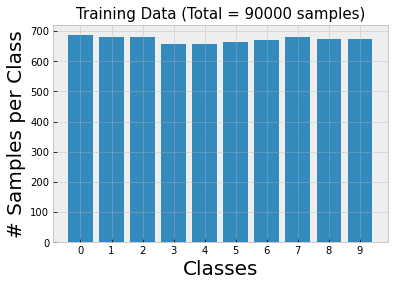

In [3]:
# Counting number samples per class
vals, counts = np.unique(t_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(X_train.shape[1])+' samples)',size=15);

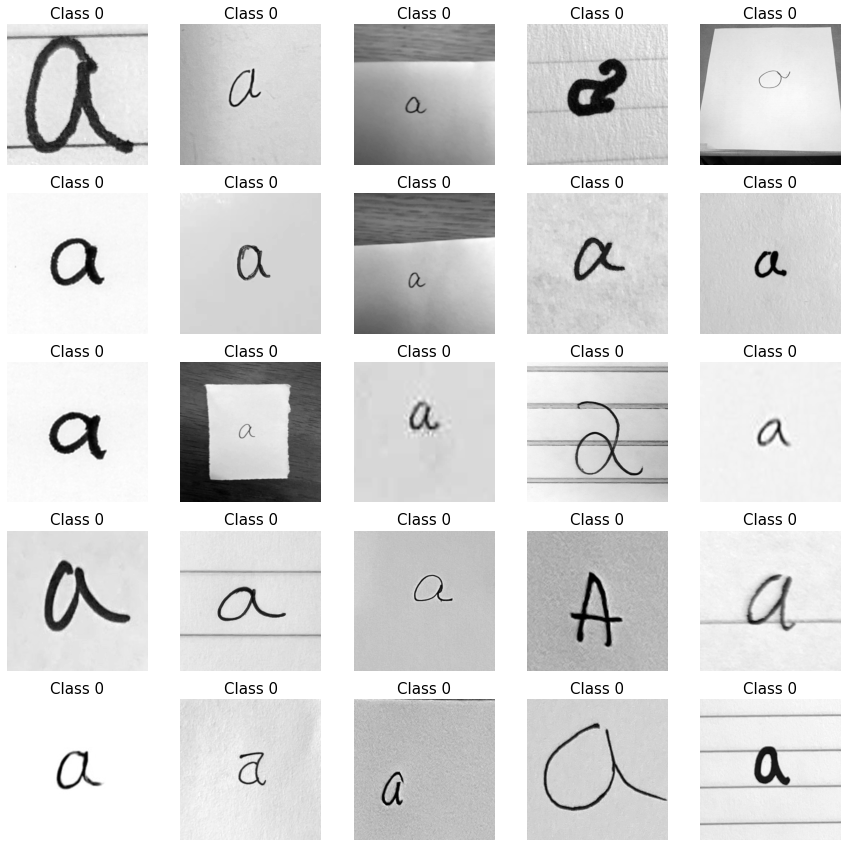

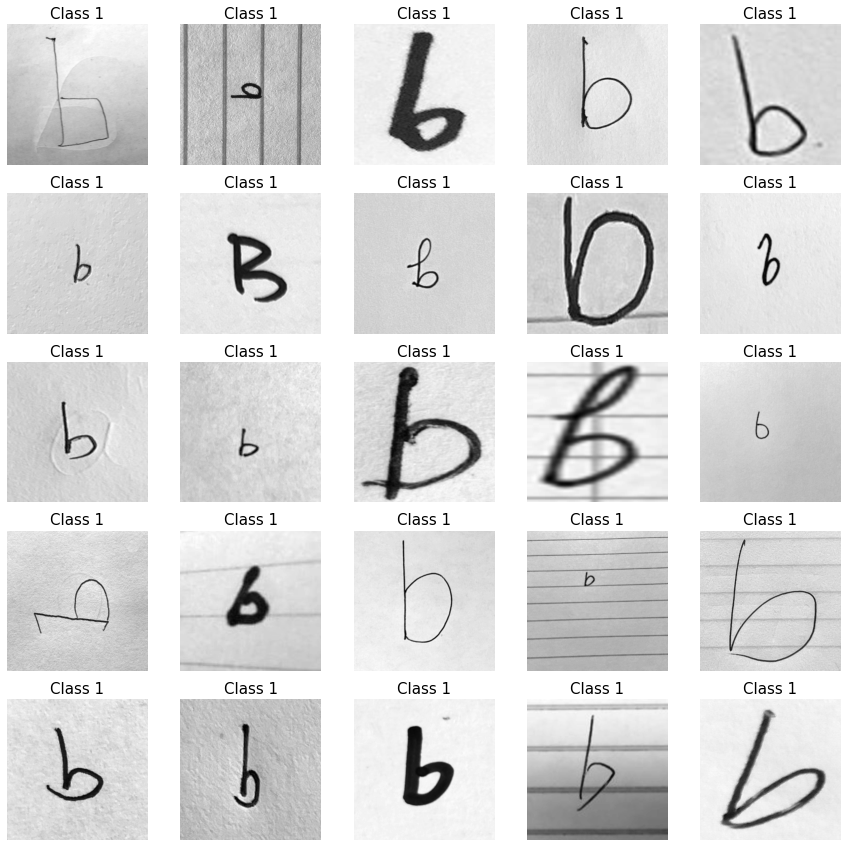

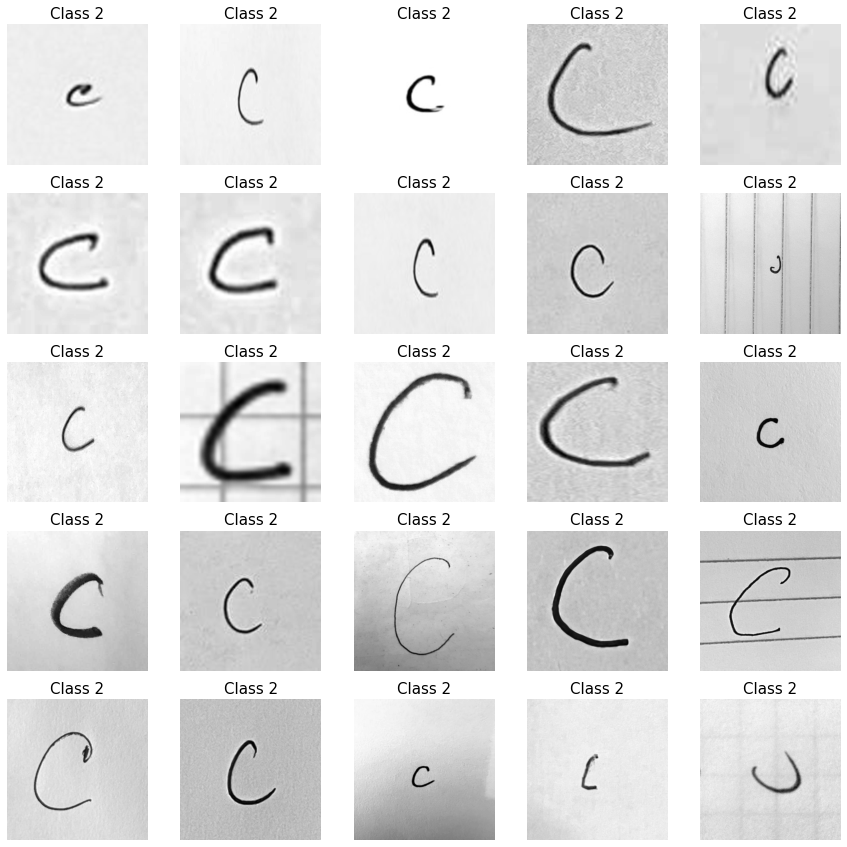

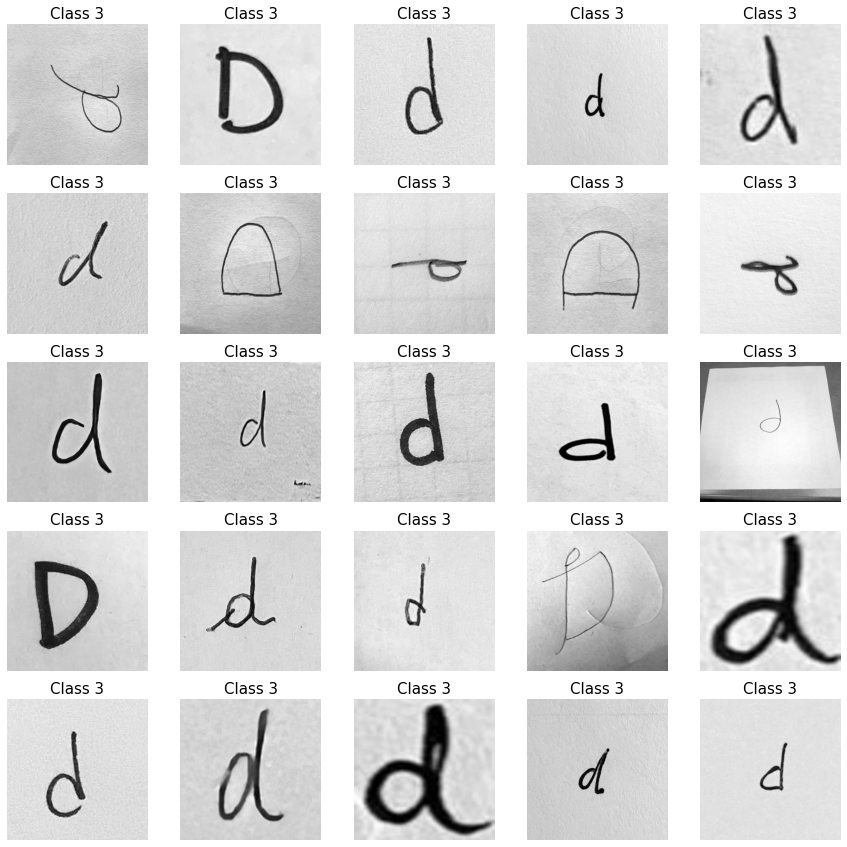

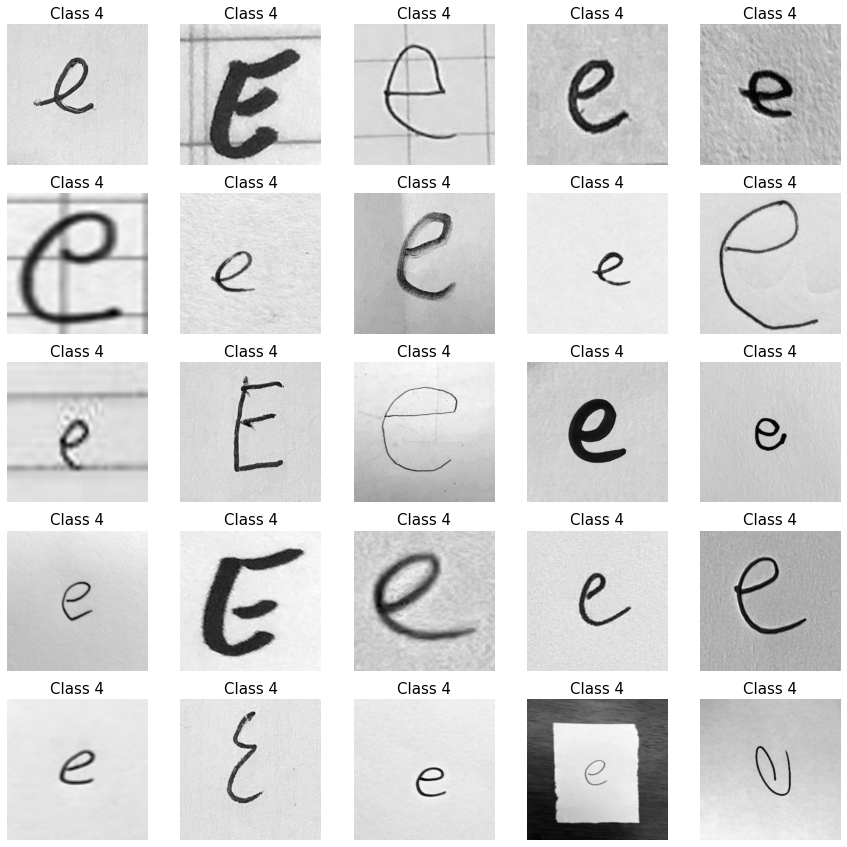

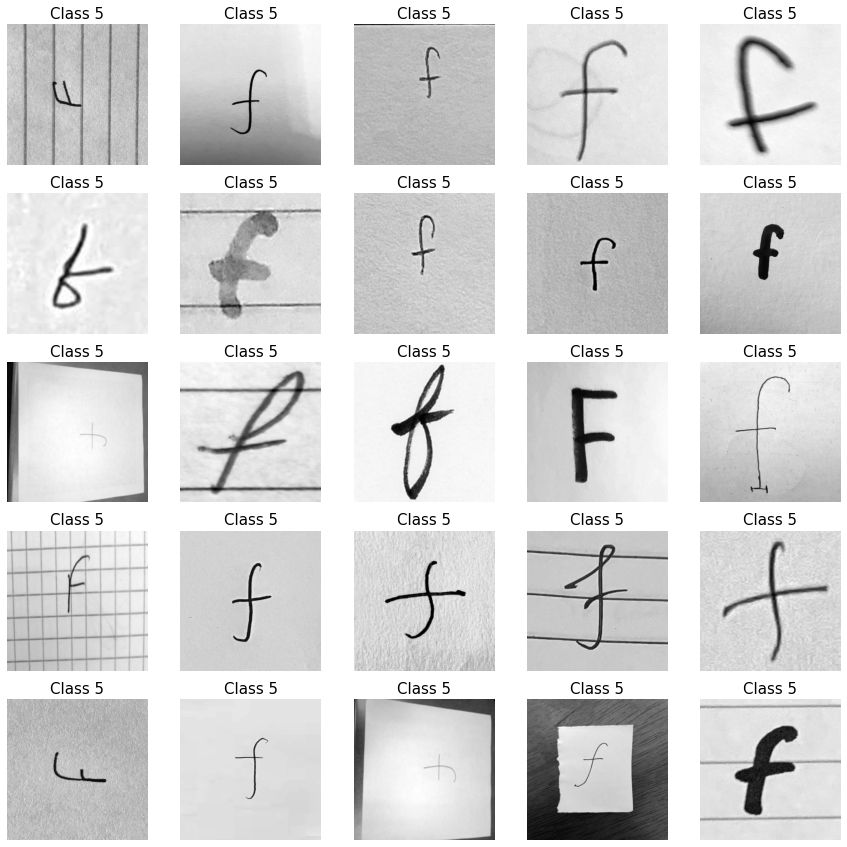

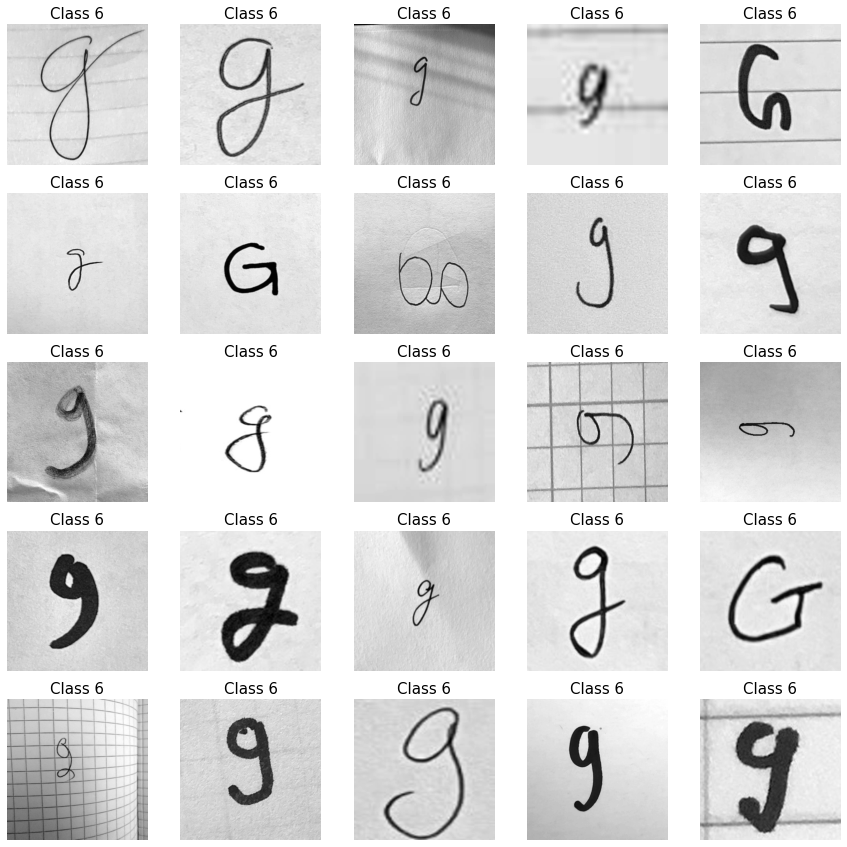

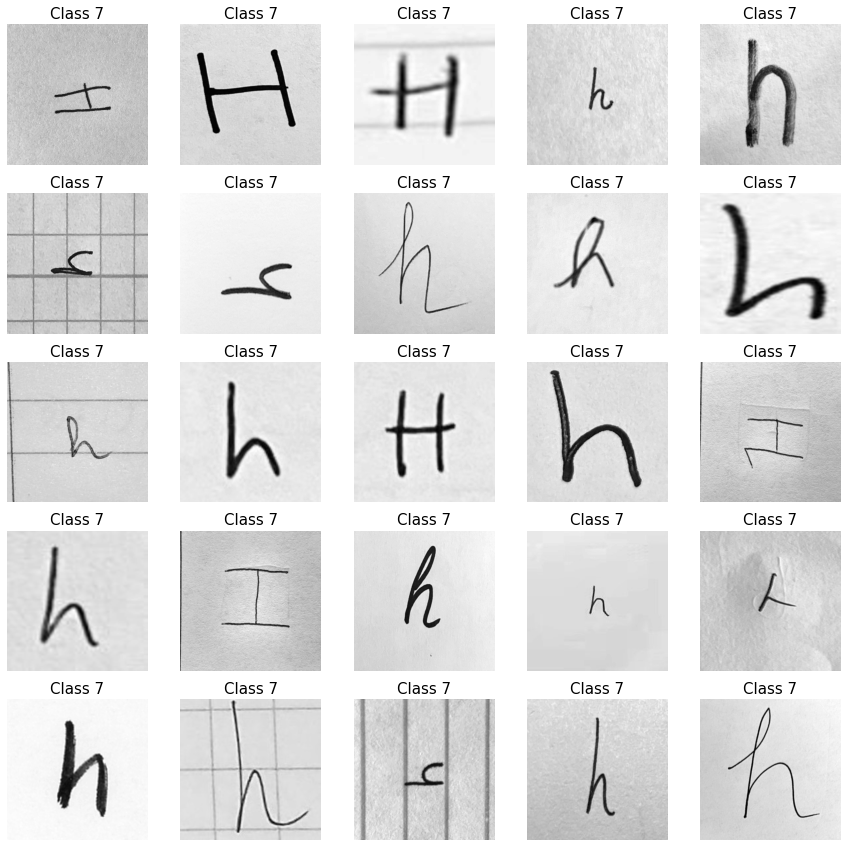

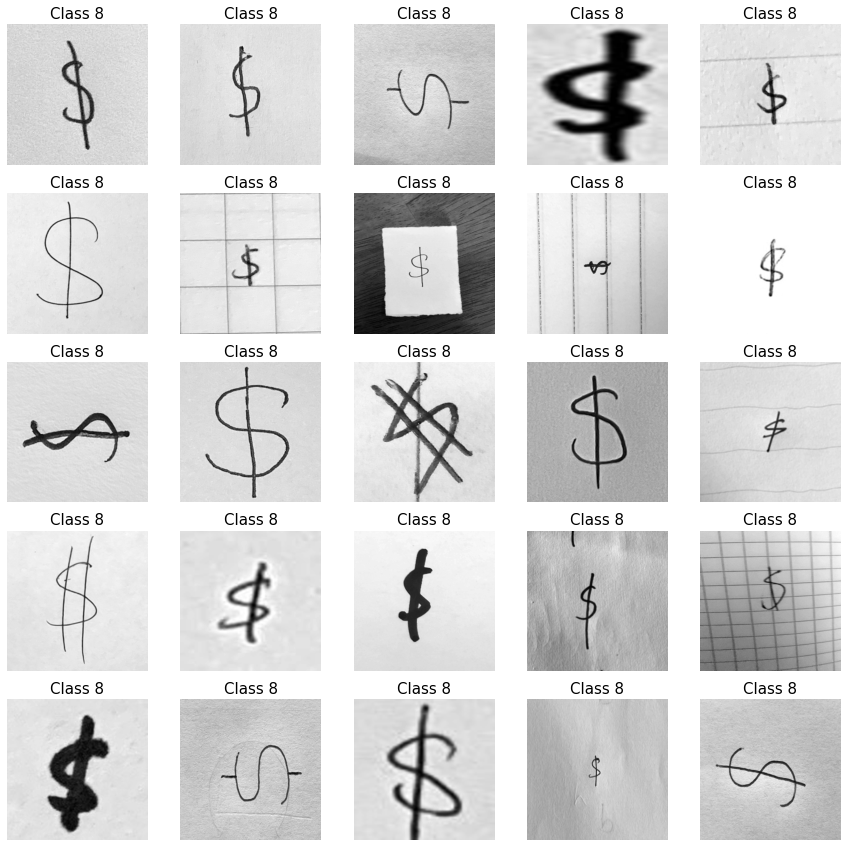

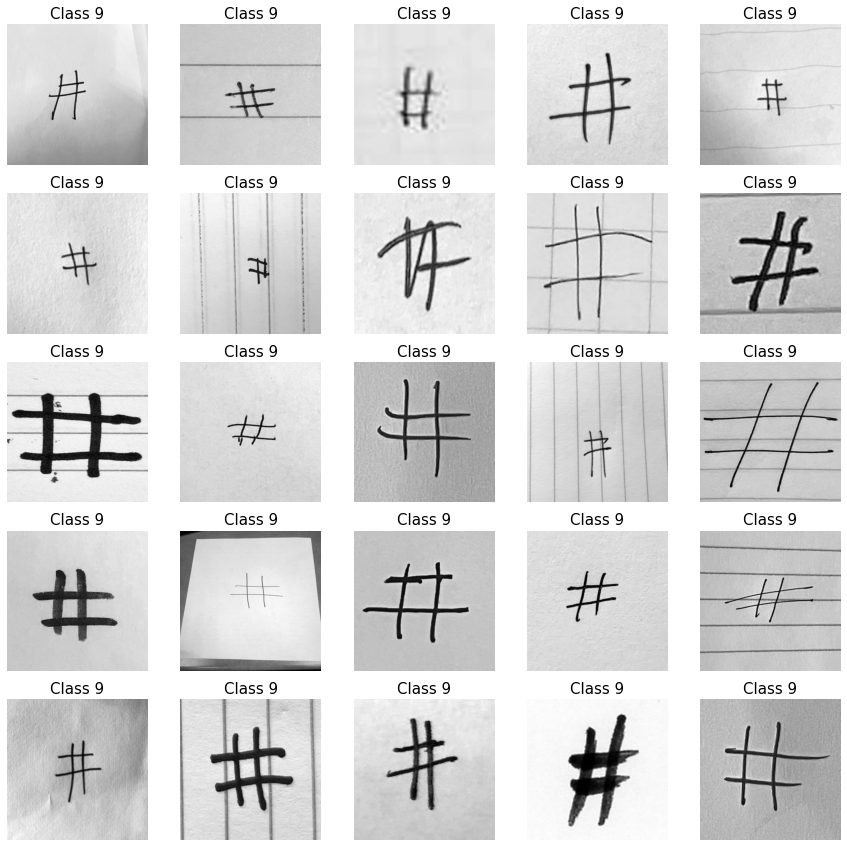

In [4]:
# Displaying some random examples per class

for i in range(0,10):
    rnd_sample = npr.permutation(np.where(t_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(25):
        fig.add_subplot(5,5,j+1)
        plt.imshow(X_train[rnd_sample[j],:].reshape((300,300)),cmap='gray')
        plt.axis('off');plt.title('Class '+str(int(t_train[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')

#### Notes-
1. After looking at the random images for different classes from the training dataset, I have observed that the images are of different orientations, different backgrounds, and different thickness.
2. The size of the images is 300*300 pixels, which will make the computation expensive. So I will downsize the images to make is less computationally taxing.

### Data preprocessing

Creating new downsampled datasets

In [6]:
X_train_resize = np.zeros((X_train.shape[0],2500))
for i in range(X_train.shape[0]):
    im1 = X_train[i,:].reshape(300,300)
    res = cv2.resize(im1,dsize=(50,50),interpolation = cv2.INTER_CUBIC)
    X_train_resize[i] = res.reshape(2500)

X_test_resize = np.zeros((X_test.shape[0],2500))
for i in range(X_test.shape[0]):
    im1 = X_test[i,:].reshape(300,300)
    res = cv2.resize(im1,dsize=(50,50),interpolation = cv2.INTER_CUBIC)
    X_test_resize[i] = res.reshape(2500)

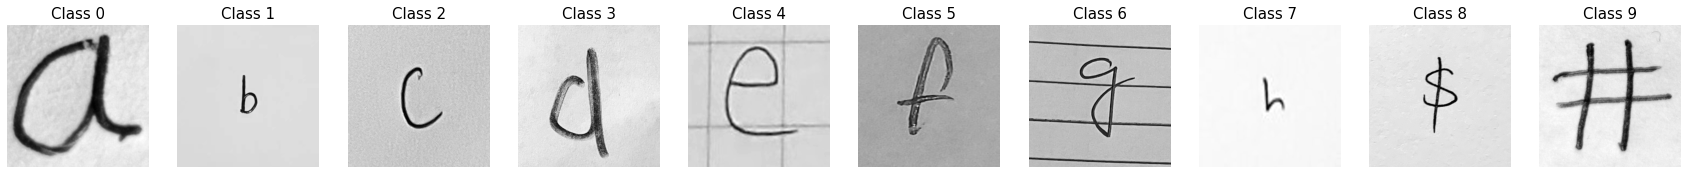

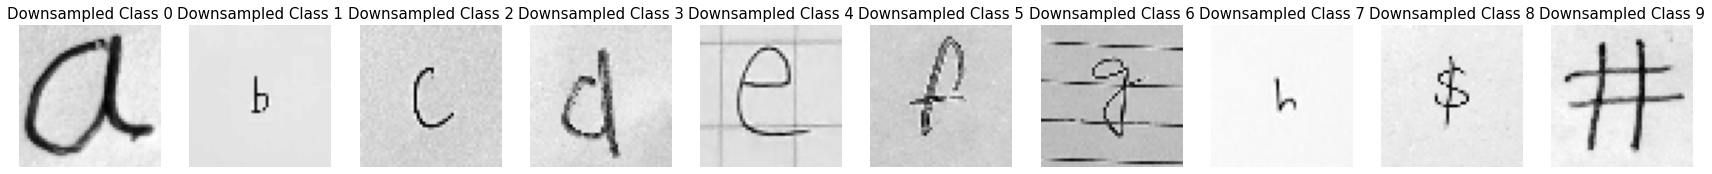

In [7]:
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[index[0][0],:].reshape((300,300)),cmap='gray')
    plt.title('Class '+str(int(t_train[index[0][0]])),size=15);plt.axis('off')
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow(X_train_resize[index[0][0],:].reshape((50,50)),cmap='gray')
    plt.title('Downsampled Class '+str(int(t_train[index[0][0]])),size=15);plt.axis('off')

## Question 1

I will be implementing Logistic regression and SVM classifier with RFE

### Logistic Regression with RFE

In [8]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
rfe_pipe = Pipeline([('StandardScaler',StandardScaler()),
        ('RFE',RFE(estimator=lr, step=10))])
rfe_pipe

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('RFE',
                 RFE(estimator=LogisticRegression(C=0.1, penalty='l1',
                                                  random_state=42,
                                                  solver='liblinear'),
                     step=10))])

In [9]:
rfe_pipe.fit(X_train_resize,t_train)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('RFE',
                 RFE(estimator=LogisticRegression(C=0.1, penalty='l1',
                                                  random_state=42,
                                                  solver='liblinear'),
                     step=10))])

Save the pipeline

In [10]:
joblib.dump(rfe_pipe,"final_logisticregression_rfe_model.pkl")

['final_logisticregression_rfe_model.pkl']

##### To identify which pixels are selected and display mask examples from the training dataset.

In [11]:
# Selected features
print("Selected features are as follow:\n", np.where(rfe_pipe.named_steps["RFE"].support_ == True))

Selected features are as follow:
 (array([   0,   10,   15, ..., 2468, 2487, 2492], dtype=int64),)


To see which features are selected, we can visualize the features selected

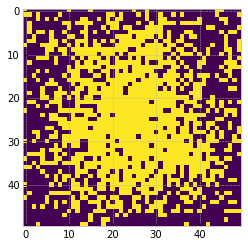

In [12]:
plt.imshow((rfe_pipe.named_steps["RFE"].support_.reshape(50,50)))

Creating mask example from training dataset

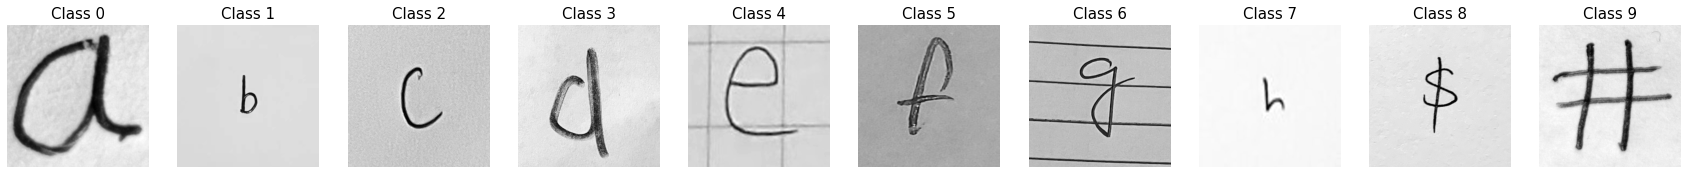

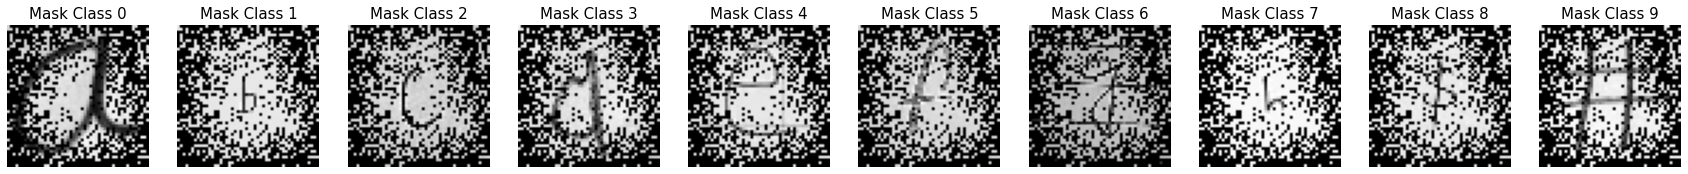

In [89]:
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[index[0][0],:].reshape((300,300)),cmap = 'gray')
    plt.axis('off');plt.title('Class '+str(int(t_train[index[0][0]])),size=15)
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow((X_train_resize[index[0][0],:].reshape(50,50)*rfe_pipe.named_steps["RFE"].support_.reshape(50,50)),cmap = 'gray')
    plt.axis('off');plt.title('Mask Class '+str(int(t_train[index[0][0]])),size=15)

### SVM classifier with RFE

In [16]:
SVM = LinearSVC(C=0.01, penalty="l1", dual=False)
SVC_pipe = Pipeline([('StandardScaler',StandardScaler()),
                    ('RFE',RFE(estimator=SVM, step=10))])

SVC_pipe

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('RFE',
                 RFE(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'),
                     step=10))])

In [17]:
SVC_pipe.fit(X_train_resize,t_train)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('RFE',
                 RFE(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'),
                     step=10))])

In [18]:
joblib.dump(SVC_pipe,"final_svm_rfe_model.pkl")

['final_svm_rfe_model.pkl']

##### To identify which pixels are selected and display mask examples from the training dataset.

In [19]:
# Selected features
print("Selected features are as follow: \n", np.where(SVC_pipe.named_steps["RFE"].support_ == True))

Selected features are as follow: 
 (array([   6,    7,    8, ..., 2490, 2491, 2492], dtype=int64),)


To see which features are selected, we can visualize the features selected

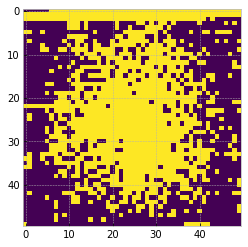

In [20]:
plt.imshow((SVC_pipe.named_steps["RFE"].support_.reshape(50,50)))

Creating mask example from training dataset

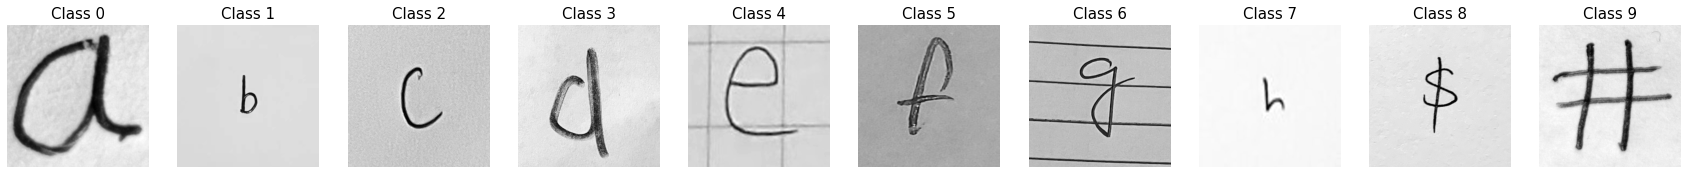

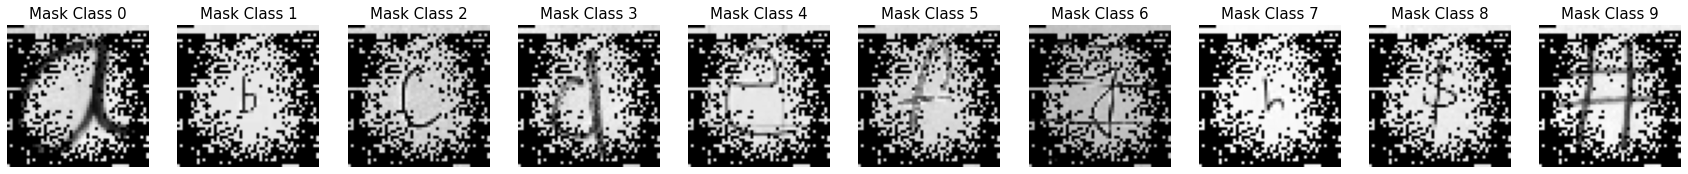

In [88]:
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[index[0][0],:].reshape((300,300)),cmap = 'gray')
    plt.axis('off');plt.title('Class '+str(int(t_train[index[0][0]])),size=15)
plt.figure(figsize=(30,30))
for i in range(10):
    index = np.where(t_train==i)
    plt.subplot(1,10,i+1)
    plt.imshow((X_train_resize[index[0][0],:].reshape(50,50)*SVC_pipe.named_steps["RFE"].support_.reshape(50,50)),cmap = 'gray')
    plt.axis('off');plt.title('Mask Class '+str(int(t_train[index[0][0]])),size=15)

## Question 2

First we have to find the number of components for which 90% variance is explained.

In [30]:
pca = PCA(n_components = 2500)
pca.fit(StandardScaler().fit_transform(X_train_resize))

PCA(n_components=2500)

In [31]:
# for the components that explain atleast 90% variance
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)
components = np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)[0][0]

In [32]:
print("The number of components for which 90% variance is explained in resized dataaset: ", components)

The number of components for which 90% variance is explained in resized dataaset:  146


Now, the classifiers needs to be trained on the original dataset, and resized dataset.

### Training Classifier on the Original dataset
The classifier used here is Logostic Regression Classifier

In [33]:
svm_or_pipe = Pipeline([('StandardScaler', StandardScaler()),
                     ('SVM', SVC(kernel = 'rbf', class_weight='balanced'))])

In [34]:
svm_or_pipe.get_params()

{'memory': None,
 'steps': [('StandardScaler', StandardScaler()),
  ('SVM', SVC(class_weight='balanced'))],
 'verbose': False,
 'StandardScaler': StandardScaler(),
 'SVM': SVC(class_weight='balanced'),
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': 'balanced',
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': -1,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SVM__shrinking': True,
 'SVM__tol': 0.001,
 'SVM__verbose': False}

In [35]:
param_grid1 ={'SVM__degree': [5,10,15,20,25]}
param_grid1

{'SVM__degree': [5, 10, 15, 20, 25]}

In [36]:
svm_or_gridsearch = GridSearchCV(svm_or_pipe,
                           param_grid=param_grid1,
                           scoring = 'accuracy',
                           cv = 5,
                           refit = True)
svm_or_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'SVM__degree': [5, 10, 15, 20, 25]},
             scoring='accuracy')

In [37]:
start = time.time()
svm_or_gridsearch.fit(X_train_resize,t_train)
end = time.time()
time_taken_svm_or = end - start

In [38]:
print("Total training time for classifier on original dataset: ",time_taken_svm_or )

Total training time for classifier on original dataset:  1886.6072945594788


Save the model

In [39]:
joblib.dump(svm_or_gridsearch.best_estimator_,"final_model_svm_original_dataset.pkl")

['final_model_svm_original_dataset.pkl']

### Training Classifier on the Reduced dataset
The classifier used here is Logostic Regression Classifier

In [40]:
svm_rd_pipe = Pipeline([('StandardScaler', StandardScaler()),
                       ('PCA',PCA(n_components=components)),
                     ('SVM', SVC(kernel = 'rbf', class_weight='balanced'))])

In [41]:
svm_rd_pipe.get_params()

{'memory': None,
 'steps': [('StandardScaler', StandardScaler()),
  ('PCA', PCA(n_components=146)),
  ('SVM', SVC(class_weight='balanced'))],
 'verbose': False,
 'StandardScaler': StandardScaler(),
 'PCA': PCA(n_components=146),
 'SVM': SVC(class_weight='balanced'),
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': 146,
 'PCA__random_state': None,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': 'balanced',
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': -1,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SVM__shrinking': True,
 'SVM__tol': 0.001,
 'SVM__verbose': False}

In [42]:
param_grid2 = {'SVM__degree': [5,10,15,20,25]}
param_grid2

{'SVM__degree': [5, 10, 15, 20, 25]}

In [43]:
svm_rd_gridsearch = GridSearchCV(svm_rd_pipe,
                           param_grid=param_grid2,
                           scoring = 'accuracy',
                           cv = 5,
                           refit = True)
svm_rd_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('PCA', PCA(n_components=146)),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'SVM__degree': [5, 10, 15, 20, 25]},
             scoring='accuracy')

In [44]:
start2 = time.time()
svm_rd_gridsearch.fit(X_train_resize,t_train)
end2 = time.time()
time_taken_svm_rd = end2 - start2

In [45]:
print("Total training time for classifier on reduced dataset: ",time_taken_svm_rd )

Total training time for classifier on reduced dataset:  134.32927584648132


Save the model

In [46]:
joblib.dump(svm_rd_gridsearch.best_estimator_,"final_model_svm_reduced_dataset.pkl")

['final_model_svm_reduced_dataset.pkl']

In [47]:
final_model_svm_reduced_dataset = svm_rd_gridsearch.best_estimator_

**After comparing the training time of classifier on original dataset, and reduced dataset, it is clearly observed that training on reduced dataset is faster.**

#### Getting the top 10 Eigenvectors

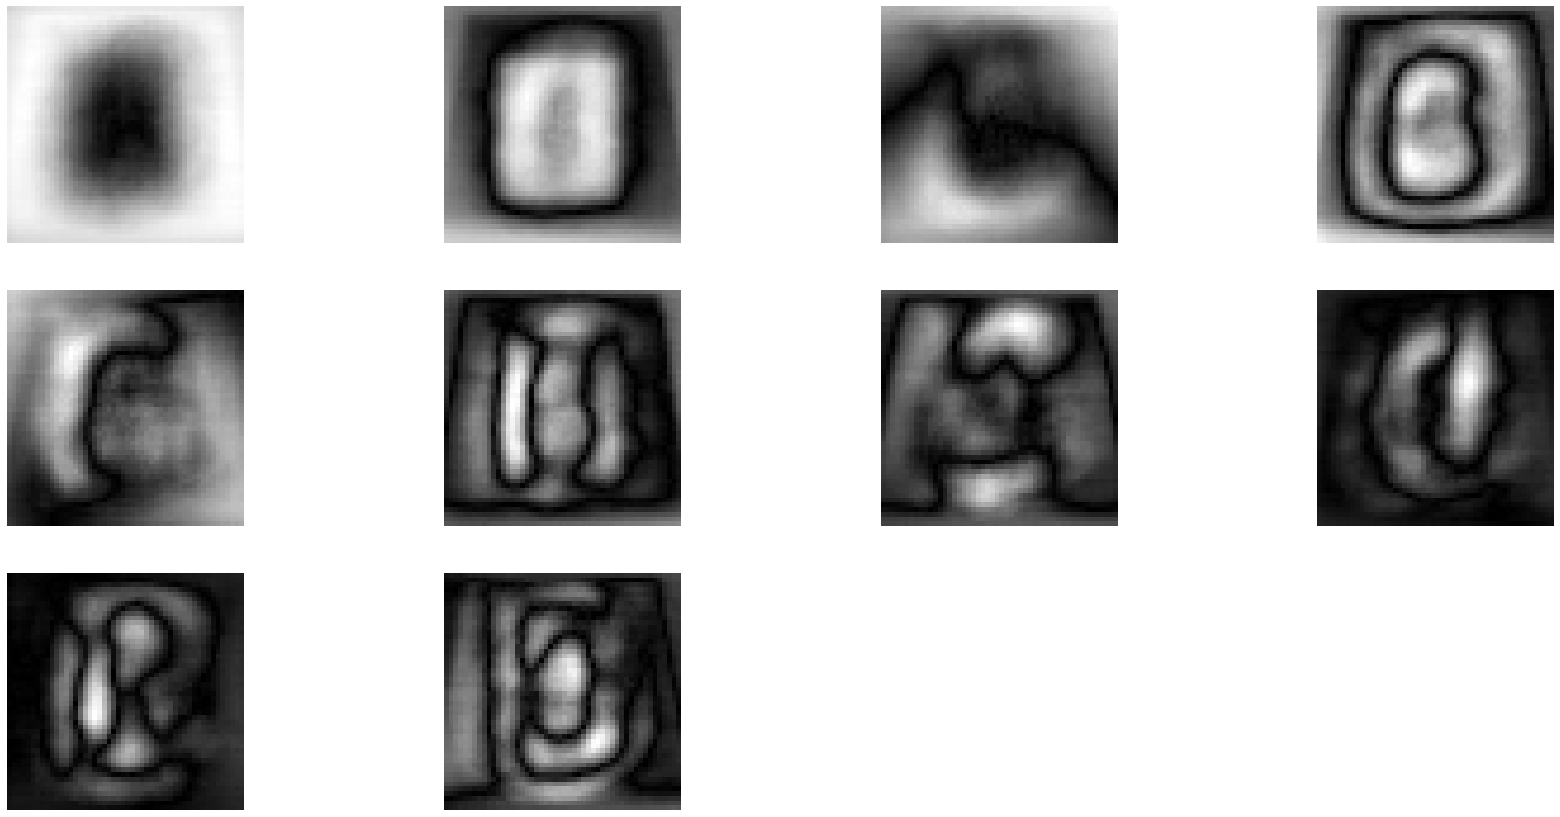

In [48]:
fig=plt.figure(figsize=(30,20))
for i in range(10):
    fig.add_subplot(4,4,i+1)
    plt.imshow(abs(final_model_svm_reduced_dataset.named_steps['PCA'].components_[i,:].reshape(50,50)),cmap='gray')
    plt.axis('off')

The eigenvectors represent combination of features from the original classes.

#### Visualizing examples of image reconstruction from PCA projections.

In [50]:
ss = StandardScaler()
ss.fit_transform(X_train_resize)
pca = PCA(n_components = 146)
pca.fit(StandardScaler().fit_transform(X_test_resize))
X_train_resize_scaled = ss.transform(X_train_resize)
X_train_pca = pca.transform(X_train_resize_scaled)
X_train_reconstruct = pca.inverse_transform((X_train_pca))
X_train_reconstructed = ss.inverse_transform(X_train_reconstruct)

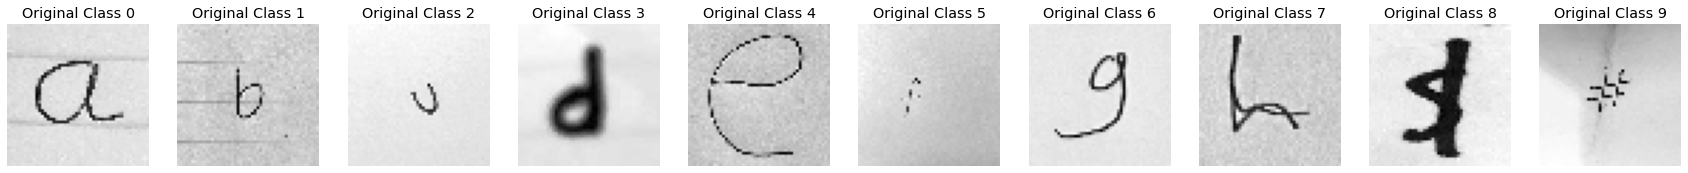

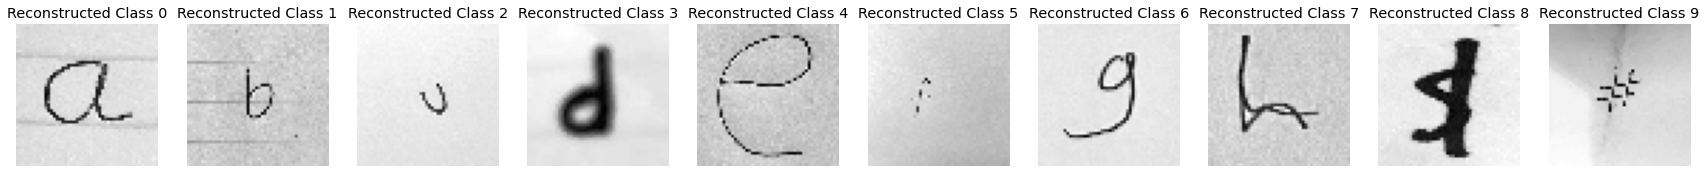

In [87]:
plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train_resize[np.where(t_train==i)[0][1],:].reshape((50,50)), cmap='gray')
    plt.title('Original Class '+str(i)); plt.axis('off');
plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train_reconstructed[np.where(t_train==i)[0][1],:].reshape((50,50)), cmap='gray')
    plt.title('Reconstructed Class '+str(i)); plt.axis('off');

## Question 3

### Fisher's Linear Discriminant Analysis (LDA)

In [53]:
lda_pipe = Pipeline([('StandardScaler', StandardScaler()),
                    ('LDA',LDA(n_components = 2))])
#lda pipeline to reduce dataset to 2 dimensions

In [54]:
lda_out_rd = lda_pipe.fit_transform(X_train_resize,t_train)

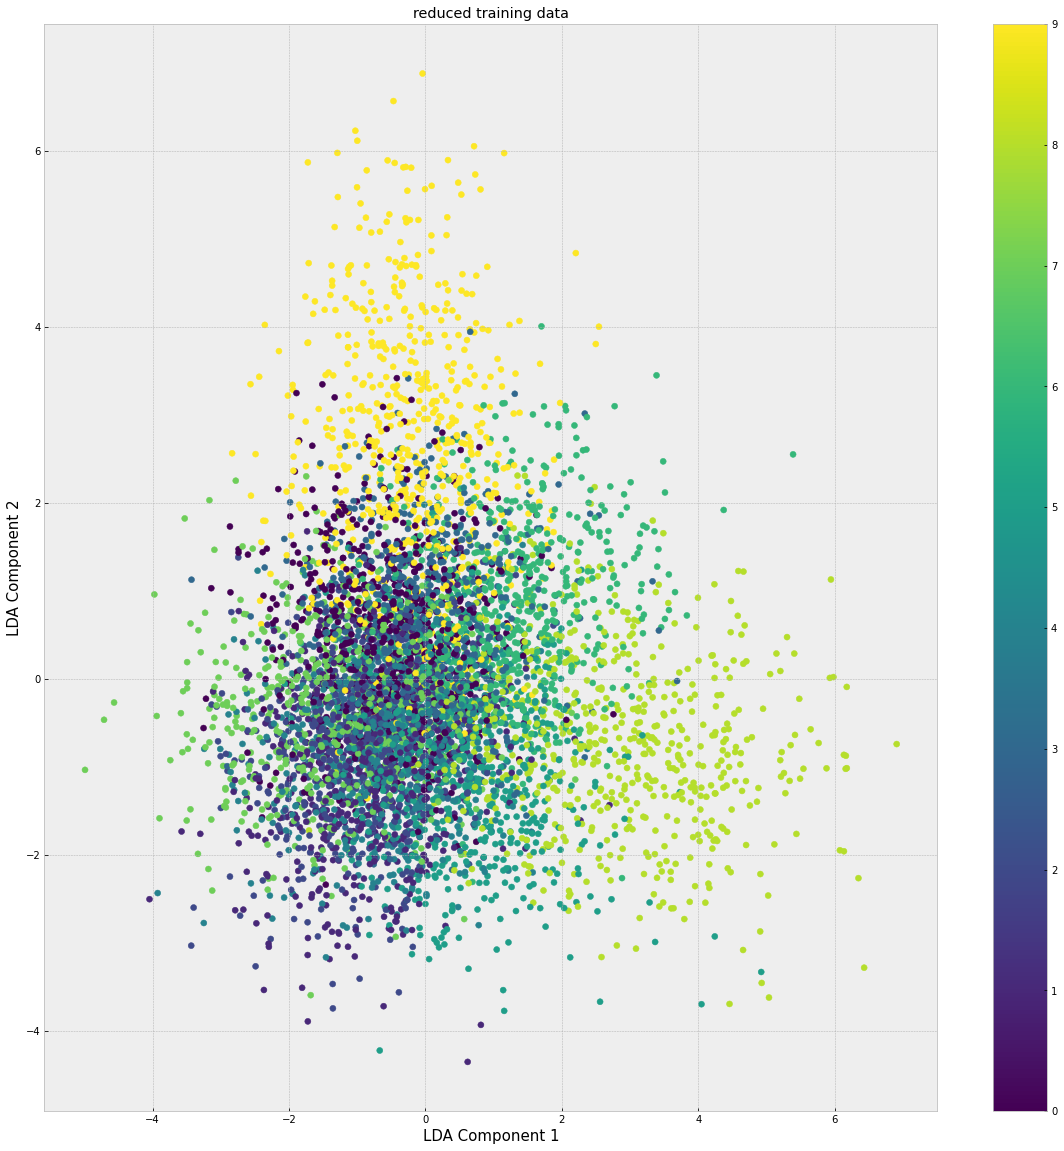

In [55]:
plt.figure(figsize=(20,20))
plt.scatter(lda_out_rd[:,0], lda_out_rd[:,1], c=t_train)
plt.xlabel('LDA Component 1', size=15)
plt.ylabel('LDA Component 2', size=15)
plt.title('reduced training data')
plt.colorbar();

### t-SNE

In [56]:
ts_pipe = Pipeline([('StandardScaler', StandardScaler()),
                    ('TSNE',TSNE(n_components = 2))])
#t-SNE pipeline to reduce dataset to 2 dimensions

In [57]:
ts_out_rd = ts_pipe.fit_transform(X_train_resize,t_train)

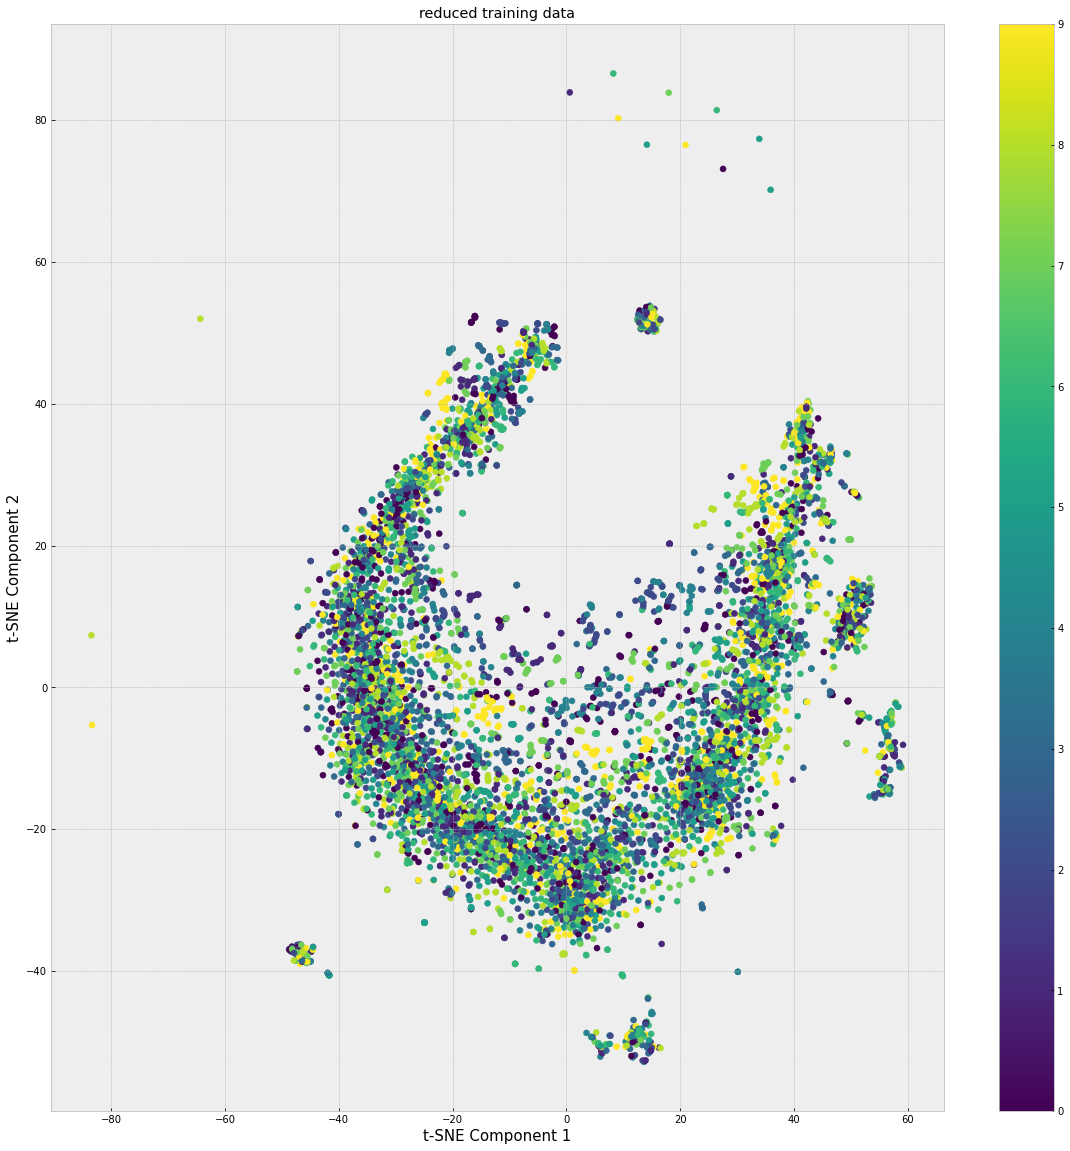

In [58]:
plt.figure(figsize=(20,20))
plt.scatter(ts_out_rd[:,0], ts_out_rd[:,1], c=t_train)
plt.xlabel('t-SNE Component 1', size=15)
plt.ylabel('t-SNE Component 2', size=15)
plt.title('reduced training data')
plt.colorbar();

### PCA

In [59]:
pca_pipe = Pipeline([('StandardScaler', StandardScaler()),
                    ('PCA',PCA(n_components = 2))])
#PCA pipeline to reduce dataset to 2 dimensions

In [60]:
pca_out_rd = pca_pipe.fit_transform(X_train_resize)

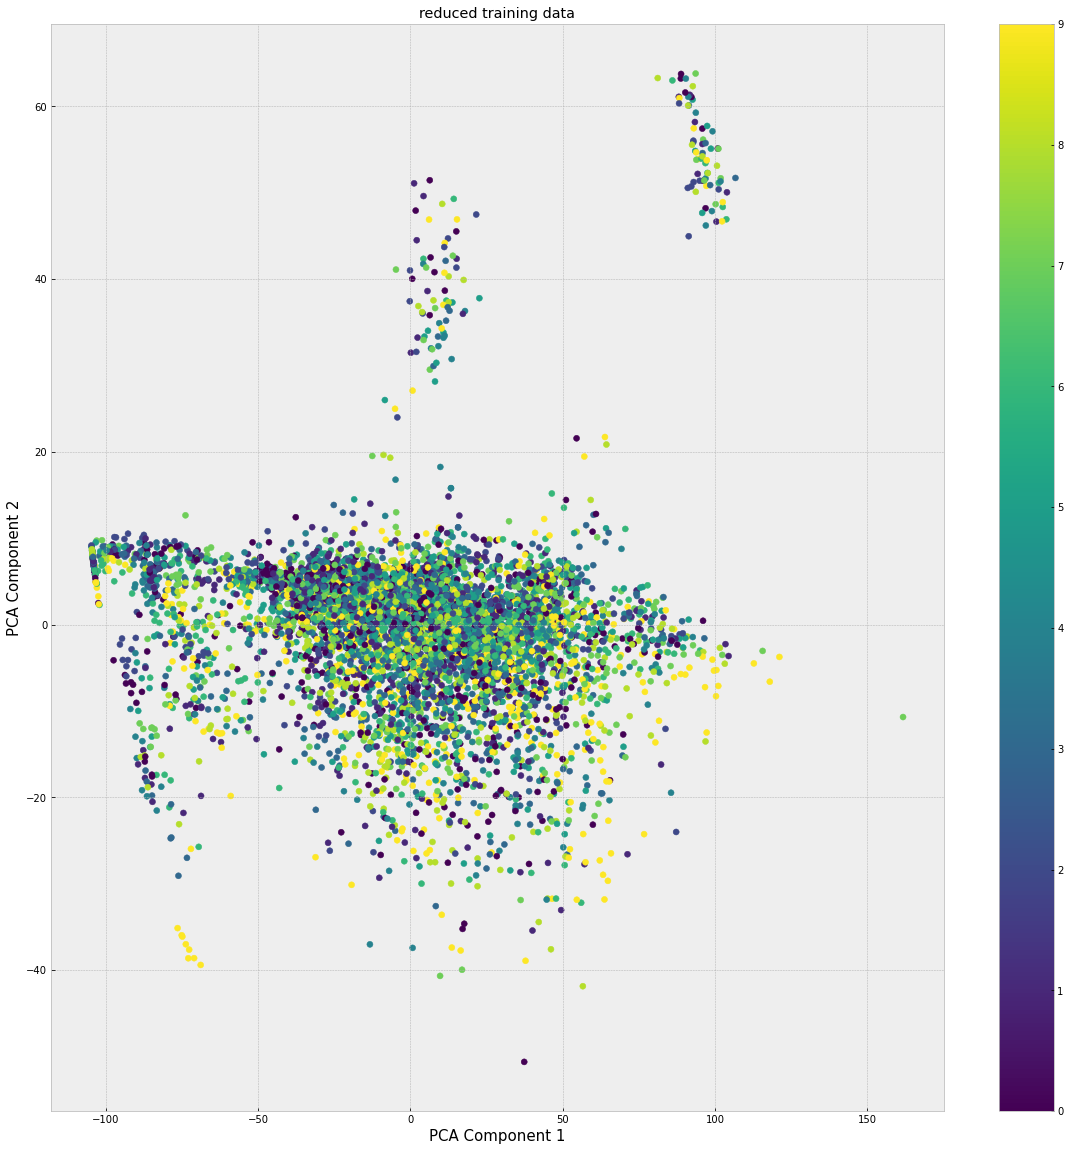

In [61]:
plt.figure(figsize=(20,20))
plt.scatter(pca_out_rd[:,0], pca_out_rd[:,1], c=t_train)
plt.xlabel('PCA Component 1', size=15)
plt.ylabel('PCA Component 2', size=15)
plt.title('reduced training data')
plt.colorbar();

In [86]:
joblib.dump(lda_pipe,"lda_model.pkl")
joblib.dump(ts_pipe,"ts_model.pkl")
joblib.dump(pca_pipe,"pca_model.pkl")

['pca_model.pkl']

## Question 4

I will be using MDS,ISOMAP, and LLE as the manifold learning algorithm. Furthermore, I will train SVM on the processed dataset.

### MDS

In [102]:
# For MDS I will create a custom class.
#This code has been based on the pipeline lectures
class MDS2(BaseEstimator, TransformerMixin):
    def __init__ (self,n): # no *args or **kargs
        self.n = n
        self.MDS = MDS(n_components=self.n,dissimilarity = 'euclidean',max_iter = 50)
    def fit(self, X, y=None):
        self.MDS.fit_transform(X)
        return self # nothing else to do
    def transform(self, X):
        return self.MDS.fit_transform(X)

In [103]:
mds_pipe = Pipeline([('StandardScaler', StandardScaler()),
                     ('MDS2',MDS2(2)),
                     ('SVM', SVC(kernel = 'rbf', class_weight='balanced',max_iter = 100))])

In [104]:
mds_pipe.get_params()

{'memory': None,
 'steps': [('StandardScaler', StandardScaler()),
  ('MDS2', MDS2(n=2)),
  ('SVM', SVC(class_weight='balanced', max_iter=100))],
 'verbose': False,
 'StandardScaler': StandardScaler(),
 'MDS2': MDS2(n=2),
 'SVM': SVC(class_weight='balanced', max_iter=100),
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'MDS2__n': 2,
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': 'balanced',
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': 100,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SVM__shrinking': True,
 'SVM__tol': 0.001,
 'SVM__verbose': False}

In [105]:
param_grid3 = {'MDS2__n':[130,140,150,160,170]}

In [106]:
mds_gridsearch = GridSearchCV(mds_pipe,
                           param_grid=param_grid3,
                           scoring = 'accuracy',
                           cv = 3,
                           refit = True)
mds_gridsearch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('MDS2', MDS2(n=2)),
                                       ('SVM',
                                        SVC(class_weight='balanced',
                                            max_iter=100))]),
             param_grid={'MDS2__n': [130, 140, 150, 160, 170]},
             scoring='accuracy')

In [107]:
mds_gridsearch.fit(X_train_resize,t_train);  #this takes a very long time

In [108]:
final_mds_model = mds_gridsearch.best_estimator_;

In [109]:
joblib.dump(final_mds_model,"final_MDS_model.pkl")

### ISOMAP

In [90]:
iso_pipe = Pipeline([('StandardScaler', StandardScaler()),
                        ('Isomap',Isomap()),
                        ('SVM', SVC(kernel = 'rbf', class_weight='balanced'))])
iso_pipe.get_params()

{'memory': None,
 'steps': [('StandardScaler', StandardScaler()),
  ('Isomap', Isomap()),
  ('SVM', SVC(class_weight='balanced'))],
 'verbose': False,
 'StandardScaler': StandardScaler(),
 'Isomap': Isomap(),
 'SVM': SVC(class_weight='balanced'),
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'Isomap__eigen_solver': 'auto',
 'Isomap__max_iter': None,
 'Isomap__metric': 'minkowski',
 'Isomap__metric_params': None,
 'Isomap__n_components': 2,
 'Isomap__n_jobs': None,
 'Isomap__n_neighbors': 5,
 'Isomap__neighbors_algorithm': 'auto',
 'Isomap__p': 2,
 'Isomap__path_method': 'auto',
 'Isomap__tol': 0,
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': 'balanced',
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': -1,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SVM__shrinking': True,
 'SVM__t

In [91]:
param_grid4 = {'Isomap__n_components':[130,140,150,160,170]}

In [92]:
iso_gridsearch = GridSearchCV(iso_pipe,
                           param_grid=param_grid4,
                           scoring = 'accuracy',
                           cv = 3,
                           refit = True)
iso_gridsearch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('Isomap', Isomap()),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'Isomap__n_components': [130, 140, 150, 160, 170]},
             scoring='accuracy')

In [93]:
iso_gridsearch.fit(X_train_resize,t_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('Isomap', Isomap()),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'Isomap__n_components': [130, 140, 150, 160, 170]},
             scoring='accuracy')

In [94]:
final_iso_model = iso_gridsearch.best_estimator_

In [95]:
joblib.dump(final_iso_model,"final_iso_model.pkl")

['final_iso_model.pkl']

### LLE

In [96]:
lle_pipe = Pipeline([('StandardScaler', StandardScaler()),
                        ('LLE',LLE()),
                        ('SVM', SVC(kernel = 'rbf', class_weight='balanced'))])
lle_pipe.get_params()

{'memory': None,
 'steps': [('StandardScaler', StandardScaler()),
  ('LLE', LocallyLinearEmbedding()),
  ('SVM', SVC(class_weight='balanced'))],
 'verbose': False,
 'StandardScaler': StandardScaler(),
 'LLE': LocallyLinearEmbedding(),
 'SVM': SVC(class_weight='balanced'),
 'StandardScaler__copy': True,
 'StandardScaler__with_mean': True,
 'StandardScaler__with_std': True,
 'LLE__eigen_solver': 'auto',
 'LLE__hessian_tol': 0.0001,
 'LLE__max_iter': 100,
 'LLE__method': 'standard',
 'LLE__modified_tol': 1e-12,
 'LLE__n_components': 2,
 'LLE__n_jobs': None,
 'LLE__n_neighbors': 5,
 'LLE__neighbors_algorithm': 'auto',
 'LLE__random_state': None,
 'LLE__reg': 0.001,
 'LLE__tol': 1e-06,
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': 'balanced',
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': -1,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SV

In [97]:
param_grid5= {'LLE__n_components':[130,140,150,160,170]}

In [98]:
lle_gridsearch = GridSearchCV(lle_pipe,
                           param_grid=param_grid5,
                           scoring = 'accuracy',
                           cv = 3,
                           refit = True)
lle_gridsearch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('LLE', LocallyLinearEmbedding()),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'LLE__n_components': [130, 140, 150, 160, 170]},
             scoring='accuracy')

In [99]:
lle_gridsearch.fit(X_train_resize,t_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('LLE', LocallyLinearEmbedding()),
                                       ('SVM', SVC(class_weight='balanced'))]),
             param_grid={'LLE__n_components': [130, 140, 150, 160, 170]},
             scoring='accuracy')

In [100]:
final_lle_model = lle_gridsearch.best_estimator_

In [101]:
joblib.dump(final_lle_model,"final_lle_model.pkl")

['final_lle_model.pkl']